# **Copy Data from Drive to Colab Hard**

In [1]:
!cp /content/drive/MyDrive/Masoudi/dataset.zip .

In [2]:
!unzip -qq dataset.zip

In [1]:
!cp /content/drive/MyDrive/Masoudi/4.zip .
!unzip -qq 4.zip

# **util: Helper Code**

In [2]:
#!/usr/bin/env python

# Do *not* edit this script.
# These are helper functions that you can use with your code.
# Check the example code to see how to import these functions to your code.

import os, numpy as np, scipy as sp, scipy.io

### Challenge data I/O functions

# Find the folders with data files.
def find_data_folders(root_folder):
    data_folders = list()
    for x in os.listdir(root_folder):
        data_folder = os.path.join(root_folder, x)
        if os.path.isdir(data_folder):
            data_folders.append(x)
    return sorted(data_folders)

def load_challenge_data(data_folder, patient_id):
    # Define file location.
    patient_metadata_file = os.path.join(data_folder, patient_id, patient_id + '.txt')
    recording_metadata_file = os.path.join(data_folder, patient_id, patient_id + '.tsv')

    # Load non-recording data.
    patient_metadata = load_text_file(patient_metadata_file)
    recording_metadata = load_text_file(recording_metadata_file)

    # Load recordings.
    recordings = list()
    recording_ids = get_recording_ids(recording_metadata)
    for recording_id in recording_ids:
        if recording_id != 'nan':
            recording_location = os.path.join(data_folder, patient_id, recording_id)
            recording_data, sampling_frequency, channels = load_recording(recording_location)
        else:
            recording_data = None
            sampling_frequency = None
            channels = None
        recordings.append((recording_data, sampling_frequency, channels))

    return patient_metadata, recording_metadata, recordings

# Load the WFDB data for the Challenge (but not all possible WFDB files).
def load_recording(record_name):
    # Allow either the record name or the header filename.
    root, ext = os.path.splitext(record_name)
    if ext=='':
        header_file = record_name + '.hea'
    else:
        header_file = record_name

    # Load the header file.
    if not os.path.isfile(header_file):
        raise FileNotFoundError('{} recording not found.'.format(record_name))

    with open(header_file, 'r') as f:
        header = [l.strip() for l in f.readlines() if l.strip()]

    # Parse the header file.
    record_name = None
    num_signals = None
    sampling_frequency = None
    num_samples = None
    signal_files = list()
    gains = list()
    offsets = list()
    channels = list()
    initial_values = list()
    checksums = list()

    for i, l in enumerate(header):
        arrs = [arr.strip() for arr in l.split(' ')]
        # Parse the record line.
        if i==0:
            record_name = arrs[0]
            num_signals = int(arrs[1])
            sampling_frequency = float(arrs[2])
            num_samples = int(arrs[3])
        # Parse the signal specification lines.
        else:
            signal_file = arrs[0]
            gain = float(arrs[2].split('/')[0])
            offset = int(arrs[4])
            initial_value = int(arrs[5])
            checksum = int(arrs[6])
            channel = arrs[8]
            signal_files.append(signal_file)
            gains.append(gain)
            offsets.append(offset)
            initial_values.append(initial_value)
            checksums.append(checksum)
            channels.append(channel)

    # Check that the header file only references one signal file. WFDB format  allows for multiple signal files, but we have not
    # implemented that here for simplicity.
    num_signal_files = len(set(signal_files))
    if num_signal_files!=1:
        raise NotImplementedError('The header file {}'.format(header_file) \
            + ' references {} signal files; one signal file expected.'.format(num_signal_files))

    # Load the signal file.
    head, tail = os.path.split(header_file)
    signal_file = os.path.join(head, list(signal_files)[0])
    data = np.asarray(sp.io.loadmat(signal_file)['val'])

    # Check that the dimensions of the signal data in the signal file is consistent with the dimensions for the signal data given
    # in the header file.
    num_channels = len(channels)
    if np.shape(data)!=(num_channels, num_samples):
        raise ValueError('The header file {}'.format(header_file) \
            + ' is inconsistent with the dimensions of the signal file.')

    # Check that the initial value and checksums for the signal data in the signal file are consistent with the initial value and
    # checksums for the signal data given in the header file.
    for i in range(num_channels):
        if data[i, 0]!=initial_values[i]:
            raise ValueError('The initial value in header file {}'.format(header_file) \
                + ' is inconsistent with the initial value for channel'.format(channels[i]))
        if np.sum(data[i, :])!=checksums[i]:
            raise ValueError('The checksum in header file {}'.format(header_file) \
                + ' is inconsistent with the initial value for channel'.format(channels[i]))

    # Rescale the signal data using the ADC gains and ADC offsets.
    rescaled_data = np.zeros(np.shape(data), dtype=np.float32)
    for i in range(num_channels):
        rescaled_data[i, :] = (data[i, :]-offsets[i])/gains[i]

    return rescaled_data, sampling_frequency, channels

# Reorder/reselect the channels.
def reorder_recording_channels(current_data, current_channels, reordered_channels):
    if current_channels == reordered_channels:
        return current_data
    else:
        indices = list()
        for channel in reordered_channels:
            if channel in current_channels:
                i = current_channels.index(channel)
                indices.append(i)
        num_channels = len(reordered_channels)
        num_samples = np.shape(current_data)[1]
        reordered_data = np.zeros((num_channels, num_samples))
        reordered_data[:, :] = current_data[indices, :]
        return reordered_data

### Helper Challenge data I/O functions

# Load text file as a string.
def load_text_file(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data

# Get a variable from the patient metadata.
def get_variable(text, variable_name, variable_type, preserve_nan=True):
    variable = None
    for l in text.split('\n'):
        if l.startswith(variable_name):
            variable = l.split(':')[1].strip()
            if preserve_nan and variable.lower() == 'nan':
                variable = float('nan')
            else:
                variable = variable_type(variable)
            return variable

# Get a column from the recording metadata.
def get_column(string, column, variable_type, sep='\t'):
    variables = list()
    for i, l in enumerate(string.split('\n')):
        arrs = [arr.strip() for arr in l.split(sep) if arr.strip()]
        if i==0:
            column_index = arrs.index(column)
        elif arrs:
            variable = arrs[column_index]
            variable = variable_type(variable)
            variables.append(variable)
    return np.asarray(variables)

# Get the patient ID variable from the patient data.
def get_patient_id(string):
    return get_variable(string, 'Patient', str)

# Get the age variable (in years) from the patient data.
def get_age(string):
    return get_variable(string, 'Age', int)

# Get the sex variable from the patient data.
def get_sex(string):
    return get_variable(string, 'Sex', str)

# Get the ROSC variable (in minutes) from the patient data.
def get_rosc(string):
    return get_variable(string, 'ROSC', int)

# Get the OHCA variable from the patient data.
def get_ohca(string):
    return get_variable(string, 'OHCA', bool)

# Get the VFib variable from the patient data.
def get_vfib(string):
    return get_variable(string, 'VFib', bool)

# Get the TTM variable (in Celsius) from the patient data.
def get_ttm(string):
    return get_variable(string, 'TTM', int)

# Get the Outcome variable from the patient data.
def get_outcome(string):
    variable = get_variable(string, 'Outcome', str)
    if variable is None or is_nan(variable):
        raise ValueError('No outcome available. Is your code trying to load labels from the hidden data?')
    if variable == 'Good':
        variable = 0
    elif variable == 'Poor':
        variable = 1
    return variable

# Get the Outcome probability variable from the patient data.
def get_outcome_probability(string):
    variable = sanitize_scalar_value(get_variable(string, 'Outcome probability', str))
    if variable is None or is_nan(variable):
        raise ValueError('No outcome available. Is your code trying to load labels from the hidden data?')
    return variable

# Get the CPC variable from the patient data.
def get_cpc(string):
    variable = sanitize_scalar_value(get_variable(string, 'CPC', str))
    if variable is None or is_nan(variable):
        raise ValueError('No CPC score available. Is your code trying to load labels from the hidden data?')
    return variable

# Get the hour number column from the patient data.
def get_hours(string):
    return get_column(string, 'Hour', int)

# Get the time column from the patient data.
def get_times(string):
    return get_column(string, 'Time', str)

# Get the quality score column from the patient data.
def get_quality_scores(string):
    return get_column(string, 'Quality', float)

# Get the recording IDs column from the patient data.
def get_recording_ids(string):
    return get_column(string, 'Record', str)

### Challenge label and output I/O functions

# Load the Challenge labels for one file.
def load_challenge_label(string):
    if os.path.isfile(string):
        string = load_text_file(string)

    outcome = get_outcome(string)
    cpc = get_cpc(string)

    return outcome, cpc

# Load the Challenge labels for all of the files in a folder.
def load_challenge_labels(folder):
    patient_folders = find_data_folders(folder)
    num_patients = len(patient_folders)

    patient_ids = list()
    outcomes = np.zeros(num_patients, dtype=np.bool_)
    cpcs = np.zeros(num_patients, dtype=np.float64)

    for i in range(num_patients):
        patient_metadata_file = os.path.join(folder, patient_folders[i], patient_folders[i] + '.txt')
        patient_metadata = load_text_file(patient_metadata_file)

        patient_ids.append(get_patient_id(patient_metadata))
        outcomes[i] = get_outcome(patient_metadata)
        cpcs[i] = get_cpc(patient_metadata)

    return patient_ids, outcomes, cpcs

# Save the Challenge outputs for one file.
def save_challenge_outputs(filename, patient_id, outcome, outcome_probability, cpc):
    # Sanitize values, e.g., in case they are a singleton array.
    outcome = sanitize_boolean_value(outcome)
    outcome_probability = sanitize_scalar_value(outcome_probability)
    cpc = sanitize_scalar_value(cpc)

    # Format Challenge outputs.
    patient_string = 'Patient: {}'.format(patient_id)
    if outcome == 0:
        outcome = 'Good'
    elif outcome == 1:
        outcome = 'Poor'
    outcome_string = 'Outcome: {}'.format(outcome)
    outcome_probability_string = 'Outcome probability: {:.3f}'.format(float(outcome_probability))
    cpc_string = 'CPC: {:.3f}'.format(int(float(cpc)) if is_integer(cpc) else float(cpc))
    output_string = patient_string + '\n' + \
        outcome_string + '\n' + outcome_probability_string + '\n' + cpc_string + '\n'

    # Write the Challenge outputs.
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(output_string)

    return output_string

# Load the Challenge outputs for one file.
def load_challenge_output(string):
    if os.path.isfile(string):
        string = load_text_file(string)

    patient_id = get_patient_id(string)
    outcome = get_outcome(string)
    outcome_probability = get_outcome_probability(string)
    cpc = get_cpc(string)

    return patient_id, outcome, outcome_probability, cpc

# Load the Challenge outputs for all of the files in folder.
def load_challenge_outputs(folder, patient_ids):
    num_patients = len(patient_ids)
    outcomes = np.zeros(num_patients, dtype=np.bool_)
    outcome_probabilities = np.zeros(num_patients, dtype=np.float64)
    cpcs = np.zeros(num_patients, dtype=np.float64)

    for i in range(num_patients):
        output_file = os.path.join(folder, patient_ids[i], patient_ids[i] + '.txt')
        patient_id, outcome, outcome_probability, cpc = load_challenge_output(output_file)
        outcomes[i] = outcome
        outcome_probabilities[i] = outcome_probability
        cpcs[i] = cpc

    return outcomes, outcome_probabilities, cpcs

### Other helper functions

# Check if a variable is a number or represents a number.
def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

# Check if a variable is an integer or represents an integer.
def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

# Check if a variable is a finite number or represents a finite number.
def is_finite_number(x):
    if is_number(x):
        return np.isfinite(float(x))
    else:
        return False

# Check if a variable is a NaN (not a number) or represents a NaN.
def is_nan(x):
    if is_number(x):
        return np.isnan(float(x))
    else:
        return False

# Remove any quotes, brackets (for singleton arrays), and/or invisible characters.
def remove_extra_characters(x):
    return str(x).replace('"', '').replace("'", "").replace('[', '').replace(']', '').replace(' ', '').strip()

# Sanitize boolean values, e.g., from the Challenge outputs.
def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_finite_number(x) and float(x)==0) or (x in ('False', 'false', 'F', 'f')):
        return 0
    elif (is_finite_number(x) and float(x)==1) or (x in ('True', 'true', 'T', 't')):
        return 1
    else:
        return float('nan')

# Santize scalar values, e.g., from the Challenge outputs.
def sanitize_scalar_value(x):
    x = remove_extra_characters(x)
    if is_number(x):
        return float(x)
    else:
        return float('nan')

# **util: getFeatures function**

In [3]:
!pip install -q mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.4 MB/s eta 0:00:00


In [4]:
import mne
from sklearn.preprocessing import StandardScaler
def get_features(patient_metadata, recording_metadata, recording_data):
    # Extract features from the patient metadata.
    age = get_age(patient_metadata)
    sex = get_sex(patient_metadata)
    rosc = get_rosc(patient_metadata)
    ohca = get_ohca(patient_metadata)
    vfib = get_vfib(patient_metadata)
    ttm = get_ttm(patient_metadata)

    # Use one-hot encoding for sex; add more variables
    sex_features = np.zeros(2, dtype=int)
    if sex == 'Female':
        female = 1
        male   = 0
        other  = 0
    elif sex == 'Male':
        female = 0
        male   = 1
        other  = 0
    else:
        female = 0
        male   = 0
        other  = 1

    # Combine the patient features.
    patient_features = np.array([age, female, male, other, rosc, ohca, vfib, ttm])

    # Extract features from the recording data and metadata.
    channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3',
                'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'Fz-Cz', 'Cz-Pz']
    num_channels = len(channels)
    num_recordings = len(recording_data)
    print('LENGTH OF RECORDED DATASET', num_recordings)

    # Compute mean and standard deviation for each channel for each recording.
    available_signal_data = list()
    for i in range(num_recordings):
        signal_data, sampling_frequency, signal_channels = recording_data[i]
        if signal_data is not None:
            signal_data = reorder_recording_channels(signal_data, signal_channels, channels) # Reorder the channels in the signal data, as needed, for consistency across different recordings.
            available_signal_data.append(signal_data)

    if len(available_signal_data) > 0:
        available_signal_data = np.hstack(available_signal_data)
        signal_mean = np.nanmean(available_signal_data, axis=1)
        signal_std  = np.nanstd(available_signal_data, axis=1)
    else:
        signal_mean = float('nan') * np.ones(num_channels)
        signal_std  = float('nan') * np.ones(num_channels)

    # Compute the power spectral density for the delta, theta, alpha, and beta frequency bands for each channel of the most
    # recent recording.
    index = None
    for i in reversed(range(num_recordings)):
        signal_data, sampling_frequency, signal_channels = recording_data[i]
        if signal_data is not None:
            index = i
            break

    if index is not None:
        signal_data, sampling_frequency, signal_channels = recording_data[index]
        signal_data = reorder_recording_channels(signal_data, signal_channels, channels) # Reorder the channels in the signal data, as needed, for consistency across different recordings.

        delta_psd, _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency,  fmin=0.5,  fmax=8.0, verbose=False)
        theta_psd, _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency,  fmin=4.0,  fmax=8.0, verbose=False)
        alpha_psd, _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency,  fmin=8.0, fmax=12.0, verbose=False)
        beta_psd,  _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency, fmin=12.0, fmax=30.0, verbose=False)

        delta_psd_mean = np.nanmean(delta_psd, axis=1)
        theta_psd_mean = np.nanmean(theta_psd, axis=1)
        alpha_psd_mean = np.nanmean(alpha_psd, axis=1)
        beta_psd_mean  = np.nanmean(beta_psd,  axis=1)

        quality_score = get_quality_scores(recording_metadata)[index]
    else:
        delta_psd_mean = theta_psd_mean = alpha_psd_mean = beta_psd_mean = float('nan') * np.ones(num_channels)
        quality_score = float('nan')

    recording_features = np.hstack((signal_mean, signal_std, delta_psd_mean, theta_psd_mean, alpha_psd_mean, beta_psd_mean, quality_score))

    # Combine the features from the patient metadata and the recording data and metadata.
    features = np.hstack((patient_features, recording_features))

    return features

# **Generate STFT**

In [5]:
def get_EEG(recording_data):
  channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3',
                'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'Fz-Cz', 'Cz-Pz']
  num_channels = len(channels)
  num_recordings = len(recording_data)
  #print('LENGTH OF RECORDED DATASET', num_recordings)

    # Compute mean and standard deviation for each channel for each recording.
  available_signal_data = list()
  for i in range(num_recordings):
    signal_data, sampling_frequency, signal_channels = recording_data[i]
    if signal_data is not None:
      signal_data = reorder_recording_channels(signal_data, signal_channels, channels) # Reorder the channels in the signal data, as needed, for consistency across different recordings.
      available_signal_data.append(signal_data)
  if len(available_signal_data) > 0:
    available_signal_data1 = np.hstack(available_signal_data)
  return available_signal_data1    


In [6]:
from scipy.signal import butter, sosfilt, sosfreqz
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [ ]:
data_folder = "/content/content/example/training_data"
model_folder = "/content/example/model"

In [ ]:
!cp -r /content/i-care-international-cardiac-arrest-research-consortium-database-1.0/training/ICARE_0570 "/content/content/example/training_data"
!cp -r /content/i-care-international-cardiac-arrest-research-consortium-database-1.0/training/ICARE_0568 "/content/content/example/training_data"
!cp -r /content/i-care-international-cardiac-arrest-research-consortium-database-1.0/training/ICARE_0566 "/content/content/example/training_data"
!cp -r /content/i-care-international-cardiac-arrest-research-consortium-database-1.0/training/ICARE_0565 "/content/content/example/training_data"
!cp -r /content/i-care-international-cardiac-arrest-research-consortium-database-1.0/training/ICARE_0561 "/content/content/example/training_data"

In [ ]:
my_data_folder = os.path.join(model_folder, "data")
good_folder = os.path.join(my_data_folder, "Good")
poor_folder = os.path.join(my_data_folder, "Poor")

In [ ]:
os.makedirs(model_folder, exist_ok=True)

In [ ]:
os.makedirs(my_data_folder, exist_ok=True)
os.makedirs(good_folder, exist_ok=True)
os.makedirs(poor_folder, exist_ok=True)

In [ ]:
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

    1/12...
    2/12...
    3/12...
    4/12...
    5/12...
    6/12...
    7/12...
    8/12...
    9/12...
    10/12...
    11/12...
    12/12...


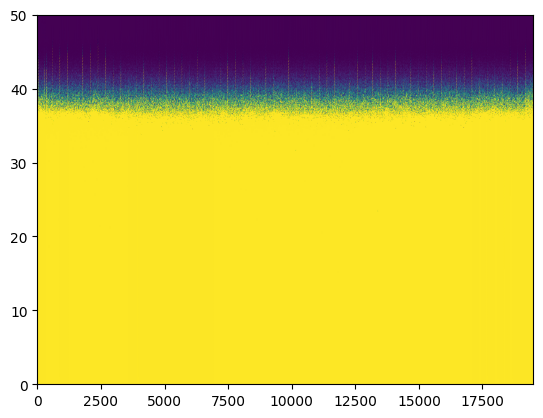

In [ ]:
lowcut = 0.5  #cutoff frequency in rad/s
highcut = 31
fs = 100 #sampling frequency in rad/s
order = 5 #order of filter

for j in range(num_patients):
    print('    {}/{}...'.format(j+1, num_patients))
    patient_id = patient_ids[j]
    patient_metadata, recording_metadata, recording_data = load_challenge_data(data_folder, patient_id)

    eeg_data = get_EEG(recording_data)
    total = 0
    for i in range(18):
      filtered_EEG = butter_bandpass_filter(np.array(eeg_data[i]),lowcut, highcut, fs, order)
      total += filtered_EEG  
    f, t, Zxx = signal.stft(np.array(total), fs, nperseg=1000)
    amp = np.abs(np.mean(total))
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')

    current_outcome = get_outcome(patient_metadata)
    if current_outcome == 0:
      plt.savefig(os.path.join(good_folder, f'{patient_id}.png'))
    elif current_outcome == 1:
      plt.savefig(os.path.join(poor_folder, f'{patient_id}.png'))

# **Model**

In [ ]:
import tensorflow as tf

In [ ]:
batch_size = 128
img_height = 256
img_width = 256

In [ ]:
seed = 123
train_ds = tf.keras.utils.image_dataset_from_directory(
  my_data_folder,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12 files belonging to 2 classes.
Using 10 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  my_data_folder,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12 files belonging to 2 classes.
Using 2 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Good', 'Poor']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from keras.constraints import max_norm
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time
from sklearn.metrics import classification_report, f1_score


# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(256, 256, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 1024, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 2))
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_16 (Bat  (None, 31, 31, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 256)       2973952   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                      

In [ ]:
checkpointer = ModelCheckpoint(monitor='val_loss', filepath='DeepConvNet.h5', verbose=1, 
                                       save_best_only=True, save_weight_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=30, factor=0.25, mode='min', 
                                      verbose=1, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [ ]:
classifier.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [ ]:
hist = classifier.fit(train_ds,
                      shuffle=False,
                  epochs=200, validation_data=val_ds,
                  callbacks=[checkpointer,reduce_lr,es])

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 1.1101 - accuracy: 0.4000
Epoch 1: val_loss improved from inf to 3.71436, saving model to DeepConvNet.h5
1/1 [==============================] - 5s 5s/step - loss: 1.1101 - accuracy: 0.4000 - val_loss: 3.7144 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.1596 - accuracy: 0.5000
Epoch 2: val_loss did not improve from 3.71436
1/1 [==============================] - 3s 3s/step - loss: 1.1596 - accuracy: 0.5000 - val_loss: 25.0610 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.2656 - accuracy: 0.4000
Epoch 3: val_loss did not improve from 3.71436
1/1 [==============================] - 4s 4s/step - loss: 1.2656 - accuracy: 0.4000 - val_loss: 53.5927 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.8000
Epoch 4: val_loss did not improve fr

KeyboardInterrupt: ignored

In [ ]:
new_model = tf.keras.models.load_model('/content/DeepConvNet.h5')